In [1]:
%matplotlib inline
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

## Classification

In [2]:
class Classifications:
    def __init__(self, shape_name, attribute, k):
        df = ps.pdio.read_files(ps.examples.get_path(shape_name))
        self.attribute = attribute
        self.shape_name = shape_name
        self.data = [i[0] for i in df[[attribute]].values.tolist()]
        self.k = k
    
    def quantiles(self):
        w = 100. / self.k
        p = np.arange(w, 100 + w, w)
        if p[-1] > 100.0:
            p[-1] = 100.0
        q = np.array([stats.scoreatpercentile(self.data, pct) for pct in p])
        return np.unique(q)

    def equal_interval(self):
        mi = min(self.data)
        ma = max(self.data)
        width = (ma - mi)/ float(self.k)
        cuts = np.arange(mi+width, ma + width, width)
        if len(cuts) > self.k:
            cuts = cuts[0:self.k]
        cuts[-1] = ma
        q = cuts.copy()
        return np.unique(q)
    
    def natural_breaks(self):
        pass
    
    def mean_standard_deviation(self):
        pass
    
    def judge(self, cla_method):
        claR = []
        if cla_method == 'QT':
            claR = self.quantiles()
        if cla_method == 'EI':
            claR = self.equal_interval()
        if cla_method == 'NB':
            claR = self.natural_breaks()
        if cla_method == 'MSD':
            claR = self.mean_standard_deviation()
        
        class_N = []
        for i, data in enumerate(self.data):
            for k, clas in enumerate(claR):
                if (data <= clas and k == 0) or (data <= clas and data > claR[k-1]):
                    c = k
                    class_N.append(c)
                else: continue
        return class_N

## Plotting

In [3]:
import matplotlib.patches as patches
import matplotlib.colors as mpc
import matplotlib.colors as colors
from pysal.contrib.viz.color import get_color_map
import struct

In [4]:
from itertools import groupby
class Plotting (Classifications):
    def __init__(self, shape_name, attribute, k):
        Classifications.__init__(self, shape_name, attribute, k)
    def distribution(self,cla_method,color,colors):
        if cla_method == 'QT':
            clalines = Classifications.quantiles(self)
        if cla_method == 'EI':
            clalines = Classifications.equal_interval(self)
        if cla_method == 'NB':
            clalines = Classifications.natural_breaks(self)
        if cla_method == 'MSD':
            clalines = sClassifications.mean_standard_deviation(self)
        
        sns.set(palette="muted", color_codes=True)
        sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})
        c = clalines.tolist()
        c.append(min(self.data))
        plt.subplot(2,1,1)
        for i in c:
            plt.axvline(x=i,color = color)
        fig1 = sns.distplot(self.data, hist=False,rug=True,kde_kws={"shade": True},color=color)

        plt.subplot(2,1,2)
        a = Classifications.judge(self, cla_method)
        a.sort()
        field = [len(list(group)) for key, group in groupby(a)]
        x=self.k
        y=field
        sns.set_context(rc={"figure.figsize": (8, 4)})
        nd = np.arange(x)
        width=1
        plt.xticks(nd+width/2., ('First','Second','Third','Fourth','Fifth', 'Sixth','Seveth','Eighth','Nineth'))
        plt.xlim(-0.5,self.k+0.5)
        fig = plt.bar(nd, y, color=sns.color_palette(colors,self.k))
        plt.legend(fig, [self.attribute], loc = "upper right", title = self.shape_name)
        plt.show()
    def legend(self,color1,color2):
        a= np.array(get_color_map(name = color1,color_encoding='rgb',k=self.k))
        b = np.array(get_color_map(name= color2,color_encoding='rgb',k=self.k))
        legend = []
        for con2, belt in enumerate(b):
            cls = []
            for con1, hue in enumerate(a):
                rgb = (belt + hue)/2
                c = '#' + struct.pack('BBB',*rgb).encode('hex')
                cls.append(c)
            legend.append(cls)
        fig = plt.figure(figsize=(2, 2))
        w = h = 1/float(self.k)
        ax = fig.add_subplot(111, aspect='equal')
        for i, cmap in enumerate(legend):
            for j, clr in enumerate(cmap):
                c = mpc.hex2color(clr)
                x = i/float(self.k)
                y = j/float(self.k)
                p = patches.Rectangle((x,y), w, h, fill=True, color=c)
                ax.add_patch(p)
        return legend

## Choropleth Mapping

In [5]:
import geopandas as gpd
from bokeh.plotting import figure, output_file, show

def choroplethmap(shape_name,class1,class2,legend):
    df = gpd.read_file(ps.examples.get_path(shape_name))
    nan = float('nan')
    lons = []
    lats = []
    df.geometry.values
    for i,shape in enumerate(df.geometry.values):
        if shape.geom_type == 'MultiPolygon':
            gx = []
            gy = []
            ng = len(shape.geoms) - 1
            for j,member in enumerate(shape.geoms):
                xy = np.array(list(member.exterior.coords))
                xs = xy[:,0].tolist()
                ys = xy[:,1].tolist()
                gx.extend(xs)
                gy.extend(ys)
                if j < ng:
                    gx.append(nan)
                    gy.append(nan)
            lons.append(gx)
            lats.append(gy)

        else:     
            xy = np.array(list(shape.exterior.coords))
            xs = xy[:,0].tolist()
            ys = xy[:,1].tolist()
            lons.append(xs)
            lats.append(ys) 

    colors = []
    for i in range(len(legend)):
        for j, color1 in enumerate(class1):
            if color1 == i:
                color2 = class2[j]
                colors.append(legend[color1][color2])

    p = figure(title="Texas", toolbar_location='left',
              plot_width=1100, plot_height=700)
    p.patches(lons,lats, fill_alpha=0.7, fill_color=colors,
             line_color="#884444", line_width=2, line_alpha=0.3)
    output_file('choropleth.html', title="choropleth.py example")
    show(p)

In [6]:
c = Classifications('south.shp', 'DNL90', 3)
classification = c.judge('QT')
classification.sort()
classification

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [7]:
c2 = Classifications('south.dbf', 'BLK90', 3)
classification2 = c2.judge('QT')
classification2.sort()
classification2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


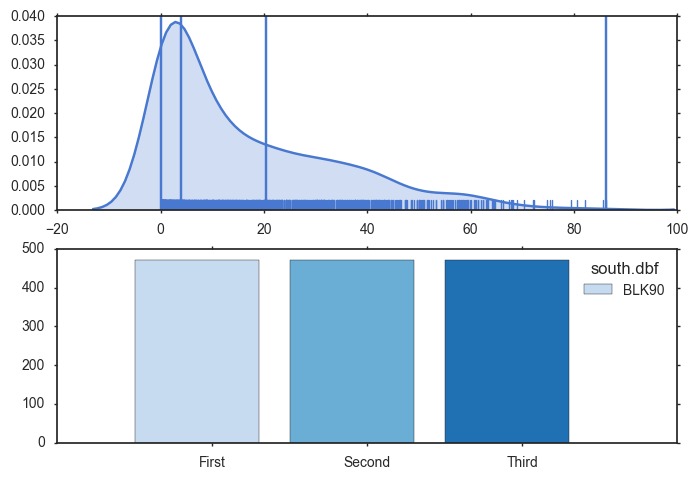

In [8]:
p1 = Plotting(shape_name = 'south.dbf', attribute ='BLK90', k=3)
p1.distribution('QT','b','Blues')

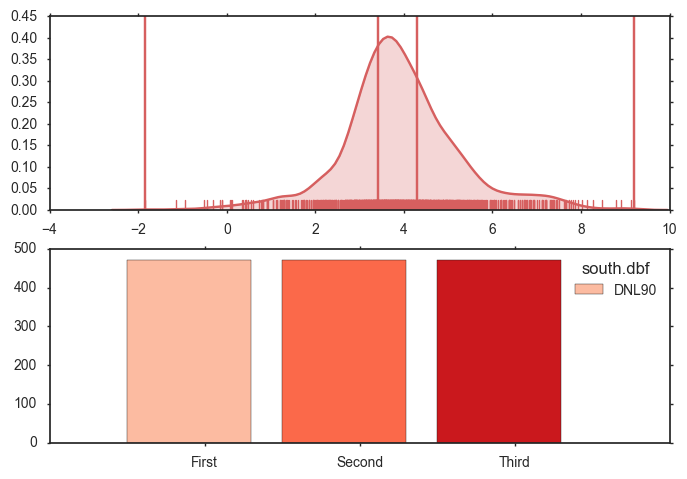

In [9]:
p2 = Plotting(shape_name = 'south.dbf', attribute ='DNL90', k=3)
p2.distribution('QT','r','Reds')

[['#eee5e4', '#edbeb4', '#de8c8e'],
 ['#ced5d9', '#cdaea9', '#be7b83'],
 ['#97b1c7', '#968a97', '#875771']]

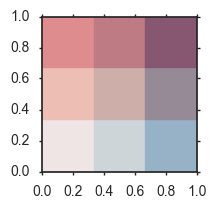

In [10]:
ld = p1.legend('Reds','Blues')
ld

In [11]:
choroplethmap('south.shp',classification,classification2,ld)